In [1]:
import feature_extraction as fe

import numpy as np

import os
import random
import pickle
import warnings
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 3
random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
def data_batcher(data, batch_size):
    random.shuffle(data)
    return [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

In [3]:
dataset = 'FMA_small'
new_feats = False


dataset_filename = f'../datasets/{dataset}.gui'
pickle_filename = f'./feats_spects-pickles/{dataset_filename.split("/")[-1][:-4]}_feats.pkl'
if new_feats or not os.path.isfile(pickle_filename):
    feats, labels = fe.extract_numfeats(dataset_filename)
    with open(pickle_filename, 'wb') as f:
        pickle.dump([feats, labels], f)
else:
    with open(pickle_filename, 'rb') as f:
        feats, labels = pickle.load(f)
    print(f'{feats.shape[0]} features extracted')

UnpicklingError: invalid load key, 'v'.

In [ ]:
scaler = StandardScaler()
scaled_feats = scaler.fit_transform(feats)

x_trainval, x_test, y_trainval, y_test = train_test_split(scaled_feats, labels, test_size=1/10) # NO TOCAR!
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=1/9)        # NO TOCAR!

train_data = [(x, y) for x, y in zip(x_train, y_train)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]
test_data = [(x, y) for x, y in zip(x_test, y_test)]

print(len(train_data), "training samples")
print(len(val_data), "validation samples")
print(len(test_data), "test samples")

In [134]:
# Fully connected neural network with one hidden layer
class DNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(DNNClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.fc4 = nn.Linear(hidden_size[2], hidden_size[3])
        self.fc5 = nn.Linear(hidden_size[3], num_classes)
        
        self.bn2 = nn.BatchNorm1d(hidden_size[1])
        self.bn3 = nn.BatchNorm1d(hidden_size[2])
        self.bn4 = nn.BatchNorm1d(hidden_size[3])
        
        self.drop_layer = nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop_layer(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop_layer(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.drop_layer(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x # we can return here the softmax, but then we should use the nll_loss instead of the cross_entropy

In [155]:
def train(log_interval, model, device, data_batches, optimizer, epoch):
    losses = []
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.train()
    
    for i, batch in enumerate(data_batches):
        x, y = list(zip(*batch))
        
        # Move tensors to the configured device
        data = torch.from_numpy(np.array(x)).float().to(device)
        target = torch.from_numpy(np.array(y)).to(device)
        
        # clear all the gradients of the optimized tensors
        optimizer.zero_grad()
    
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (i+1) % log_interval == 0:
            print(f'Train Epoch: {epoch+1} [{str((i+1)*len(data)).zfill((len(str(len_glob_data))))}/{len_glob_data} ({str(int(100. * (i+1)*len(data) / len_glob_data)).zfill(2)}%)]\tLoss: {round(loss.item(),6)}')
    return np.array(losses).mean()

In [156]:
def validate(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = []
    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            validation_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss = np.array(validation_loss).mean()
    accuracy = 100. * correct / len_glob_data

    print(f'\nValidation set: Average loss: {round(validation_loss, 4)}, Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy, validation_loss

In [157]:
def test(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len_glob_data

    print(f'Test set: Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy

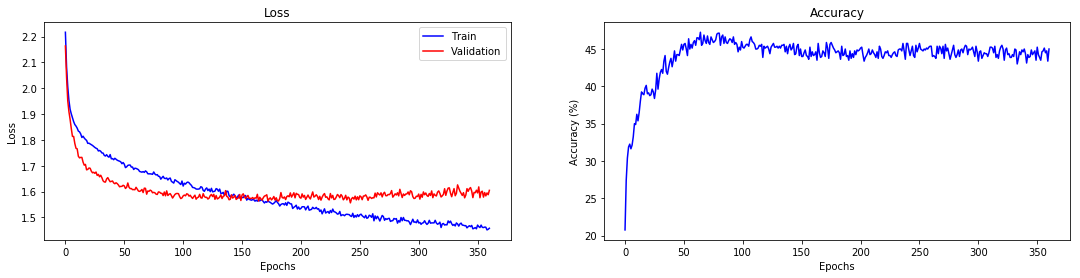

In [165]:
def plt_curves(train_losses, valid_losses, accuracies):
    fig = plt.figure()
    fig.subplots_adjust(right=2.5)

    ax1 = fig.add_subplot(121)
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.plot(train_losses, 'b-', label='Train')
    ax1.plot(valid_losses, 'r-', label='Validation')
    ax1.legend(loc='upper right')

    ax1 = fig.add_subplot(122)
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy (%)')
    ax1.plot(accuracies, 'b-')

    plt.show()

In [163]:
# Hyperparameters

input_size = 25
num_classes = 10

train_batch_size = 5 # NO TOCAR!
valid_batch_size = 100

hidden_size_list = [[256, 128, 64, 32], [512, 256, 128, 64], [128, 64, 32, 16]]
num_epochs = 100
learning_rate_list = [0.001, 0.0001, 0.00005]

In [164]:
train_data_batches = data_batcher(train_data, train_batch_size)
val_data_batches = data_batcher(val_data, valid_batch_size)

for hidden_size in hidden_size_list:
    for learning_rate in learning_rate_list:
        print(f'\n------ NEW EXPERIMENT ------\nHidden Size = {hidden_size}\tLearning Rate = {learning_rate}')
        model = DNNClassifier(input_size, hidden_size, num_classes).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train_losses = []
        valid_losses = []
        accuracies = []

        for epoch in range(num_epochs):
    
            train_loss = train(200, model, device, train_data_batches, optimizer, epoch)
            train_losses.append(train_loss)

            accuracy, valid_loss = validate(model, device, val_data_batches)
            valid_losses.append(valid_loss)
            accuracies.append(accuracy)
            
        plt_curves(train_losses, valid_losses, accuracies)

Train Epoch: 1 [1000/6395 (15%)]	Loss: 2.333955
Train Epoch: 1 [2000/6395 (31%)]	Loss: 2.332042
Train Epoch: 1 [3000/6395 (46%)]	Loss: 2.149453
Train Epoch: 1 [4000/6395 (62%)]	Loss: 2.200827
Train Epoch: 1 [5000/6395 (78%)]	Loss: 2.061065
Train Epoch: 1 [6000/6395 (93%)]	Loss: 2.166856

Validation set: Average loss: 2.1635, Accuracy: 166/800 (20%)

Train Epoch: 2 [1000/6395 (15%)]	Loss: 2.24144
Train Epoch: 2 [2000/6395 (31%)]	Loss: 2.332336
Train Epoch: 2 [3000/6395 (46%)]	Loss: 2.01494
Train Epoch: 2 [4000/6395 (62%)]	Loss: 2.111317
Train Epoch: 2 [5000/6395 (78%)]	Loss: 1.938382
Train Epoch: 2 [6000/6395 (93%)]	Loss: 2.125224

Validation set: Average loss: 2.0413, Accuracy: 219/800 (27%)

Train Epoch: 3 [1000/6395 (15%)]	Loss: 2.265705
Train Epoch: 3 [2000/6395 (31%)]	Loss: 2.232289
Train Epoch: 3 [3000/6395 (46%)]	Loss: 2.246142
Train Epoch: 3 [4000/6395 (62%)]	Loss: 1.85841
Train Epoch: 3 [5000/6395 (78%)]	Loss: 1.707339
Train Epoch: 3 [6000/6395 (93%)]	Loss: 1.805318

Validation

Train Epoch: 24 [2000/6395 (31%)]	Loss: 1.631817
Train Epoch: 24 [3000/6395 (46%)]	Loss: 1.895236
Train Epoch: 24 [4000/6395 (62%)]	Loss: 1.400462
Train Epoch: 24 [5000/6395 (78%)]	Loss: 1.444649
Train Epoch: 24 [6000/6395 (93%)]	Loss: 1.936256

Validation set: Average loss: 1.6727, Accuracy: 317/800 (39%)

Train Epoch: 25 [1000/6395 (15%)]	Loss: 2.115899
Train Epoch: 25 [2000/6395 (31%)]	Loss: 1.677348
Train Epoch: 25 [3000/6395 (46%)]	Loss: 1.784567
Train Epoch: 25 [4000/6395 (62%)]	Loss: 1.261651
Train Epoch: 25 [5000/6395 (78%)]	Loss: 1.51654
Train Epoch: 25 [6000/6395 (93%)]	Loss: 1.725788

Validation set: Average loss: 1.6746, Accuracy: 314/800 (39%)

Train Epoch: 26 [1000/6395 (15%)]	Loss: 2.365236
Train Epoch: 26 [2000/6395 (31%)]	Loss: 1.577456
Train Epoch: 26 [3000/6395 (46%)]	Loss: 1.881101
Train Epoch: 26 [4000/6395 (62%)]	Loss: 1.313651
Train Epoch: 26 [5000/6395 (78%)]	Loss: 1.66604
Train Epoch: 26 [6000/6395 (93%)]	Loss: 1.783104

Validation set: Average loss: 1.6706, Ac

Train Epoch: 47 [2000/6395 (31%)]	Loss: 1.59501
Train Epoch: 47 [3000/6395 (46%)]	Loss: 2.033984
Train Epoch: 47 [4000/6395 (62%)]	Loss: 1.126782
Train Epoch: 47 [5000/6395 (78%)]	Loss: 1.219046
Train Epoch: 47 [6000/6395 (93%)]	Loss: 1.728087

Validation set: Average loss: 1.6185, Accuracy: 353/800 (44%)

Train Epoch: 48 [1000/6395 (15%)]	Loss: 2.237382
Train Epoch: 48 [2000/6395 (31%)]	Loss: 1.602689
Train Epoch: 48 [3000/6395 (46%)]	Loss: 1.83103
Train Epoch: 48 [4000/6395 (62%)]	Loss: 1.31285
Train Epoch: 48 [5000/6395 (78%)]	Loss: 1.444988
Train Epoch: 48 [6000/6395 (93%)]	Loss: 1.658164

Validation set: Average loss: 1.6201, Accuracy: 359/800 (44%)

Train Epoch: 49 [1000/6395 (15%)]	Loss: 2.463906
Train Epoch: 49 [2000/6395 (31%)]	Loss: 1.483143
Train Epoch: 49 [3000/6395 (46%)]	Loss: 1.578085
Train Epoch: 49 [4000/6395 (62%)]	Loss: 1.339021
Train Epoch: 49 [5000/6395 (78%)]	Loss: 1.616637
Train Epoch: 49 [6000/6395 (93%)]	Loss: 1.544608

Validation set: Average loss: 1.6201, Acc

Train Epoch: 70 [2000/6395 (31%)]	Loss: 1.457547
Train Epoch: 70 [3000/6395 (46%)]	Loss: 1.924843
Train Epoch: 70 [4000/6395 (62%)]	Loss: 1.104134
Train Epoch: 70 [5000/6395 (78%)]	Loss: 1.390159
Train Epoch: 70 [6000/6395 (93%)]	Loss: 1.41647

Validation set: Average loss: 1.5899, Accuracy: 366/800 (45%)

Train Epoch: 71 [1000/6395 (15%)]	Loss: 2.130007
Train Epoch: 71 [2000/6395 (31%)]	Loss: 1.459451
Train Epoch: 71 [3000/6395 (46%)]	Loss: 1.887946
Train Epoch: 71 [4000/6395 (62%)]	Loss: 1.208258
Train Epoch: 71 [5000/6395 (78%)]	Loss: 1.48931
Train Epoch: 71 [6000/6395 (93%)]	Loss: 1.507265

Validation set: Average loss: 1.6023, Accuracy: 374/800 (46%)

Train Epoch: 72 [1000/6395 (15%)]	Loss: 1.971882
Train Epoch: 72 [2000/6395 (31%)]	Loss: 1.530207
Train Epoch: 72 [3000/6395 (46%)]	Loss: 1.943415
Train Epoch: 72 [4000/6395 (62%)]	Loss: 1.306438
Train Epoch: 72 [5000/6395 (78%)]	Loss: 1.541212
Train Epoch: 72 [6000/6395 (93%)]	Loss: 1.560784

Validation set: Average loss: 1.601, Acc

Train Epoch: 93 [2000/6395 (31%)]	Loss: 1.28473
Train Epoch: 93 [3000/6395 (46%)]	Loss: 1.332346
Train Epoch: 93 [4000/6395 (62%)]	Loss: 1.066859
Train Epoch: 93 [5000/6395 (78%)]	Loss: 1.243636
Train Epoch: 93 [6000/6395 (93%)]	Loss: 1.707875

Validation set: Average loss: 1.5819, Accuracy: 373/800 (46%)

Train Epoch: 94 [1000/6395 (15%)]	Loss: 2.076859
Train Epoch: 94 [2000/6395 (31%)]	Loss: 1.251615
Train Epoch: 94 [3000/6395 (46%)]	Loss: 1.960993
Train Epoch: 94 [4000/6395 (62%)]	Loss: 1.002482
Train Epoch: 94 [5000/6395 (78%)]	Loss: 1.119096
Train Epoch: 94 [6000/6395 (93%)]	Loss: 1.652657

Validation set: Average loss: 1.5888, Accuracy: 365/800 (45%)

Train Epoch: 95 [1000/6395 (15%)]	Loss: 1.934548
Train Epoch: 95 [2000/6395 (31%)]	Loss: 1.865671
Train Epoch: 95 [3000/6395 (46%)]	Loss: 1.500519
Train Epoch: 95 [4000/6395 (62%)]	Loss: 1.182507
Train Epoch: 95 [5000/6395 (78%)]	Loss: 1.481402
Train Epoch: 95 [6000/6395 (93%)]	Loss: 1.659532

Validation set: Average loss: 1.5922, A


Validation set: Average loss: 1.5893, Accuracy: 364/800 (45%)

Train Epoch: 116 [1000/6395 (15%)]	Loss: 2.342358
Train Epoch: 116 [2000/6395 (31%)]	Loss: 1.237515
Train Epoch: 116 [3000/6395 (46%)]	Loss: 1.577524
Train Epoch: 116 [4000/6395 (62%)]	Loss: 1.342839
Train Epoch: 116 [5000/6395 (78%)]	Loss: 1.207263
Train Epoch: 116 [6000/6395 (93%)]	Loss: 1.194478

Validation set: Average loss: 1.5758, Accuracy: 363/800 (45%)

Train Epoch: 117 [1000/6395 (15%)]	Loss: 2.271164
Train Epoch: 117 [2000/6395 (31%)]	Loss: 1.569763
Train Epoch: 117 [3000/6395 (46%)]	Loss: 1.834015
Train Epoch: 117 [4000/6395 (62%)]	Loss: 1.026674
Train Epoch: 117 [5000/6395 (78%)]	Loss: 1.102051
Train Epoch: 117 [6000/6395 (93%)]	Loss: 1.272336

Validation set: Average loss: 1.5747, Accuracy: 365/800 (45%)

Train Epoch: 118 [1000/6395 (15%)]	Loss: 2.19851
Train Epoch: 118 [2000/6395 (31%)]	Loss: 1.305034
Train Epoch: 118 [3000/6395 (46%)]	Loss: 1.790626
Train Epoch: 118 [4000/6395 (62%)]	Loss: 1.138478
Train Epo

Train Epoch: 138 [4000/6395 (62%)]	Loss: 1.273966
Train Epoch: 138 [5000/6395 (78%)]	Loss: 1.846128
Train Epoch: 138 [6000/6395 (93%)]	Loss: 1.696947

Validation set: Average loss: 1.5815, Accuracy: 363/800 (45%)

Train Epoch: 139 [1000/6395 (15%)]	Loss: 1.70651
Train Epoch: 139 [2000/6395 (31%)]	Loss: 1.455095
Train Epoch: 139 [3000/6395 (46%)]	Loss: 1.819672
Train Epoch: 139 [4000/6395 (62%)]	Loss: 0.958634
Train Epoch: 139 [5000/6395 (78%)]	Loss: 1.191018
Train Epoch: 139 [6000/6395 (93%)]	Loss: 1.118044

Validation set: Average loss: 1.5786, Accuracy: 355/800 (44%)

Train Epoch: 140 [1000/6395 (15%)]	Loss: 1.776239
Train Epoch: 140 [2000/6395 (31%)]	Loss: 1.289008
Train Epoch: 140 [3000/6395 (46%)]	Loss: 1.214828
Train Epoch: 140 [4000/6395 (62%)]	Loss: 1.244189
Train Epoch: 140 [5000/6395 (78%)]	Loss: 1.304695
Train Epoch: 140 [6000/6395 (93%)]	Loss: 1.374507

Validation set: Average loss: 1.5683, Accuracy: 362/800 (45%)

Train Epoch: 141 [1000/6395 (15%)]	Loss: 1.756903
Train Epo

Train Epoch: 161 [1000/6395 (15%)]	Loss: 2.020607
Train Epoch: 161 [2000/6395 (31%)]	Loss: 1.384798
Train Epoch: 161 [3000/6395 (46%)]	Loss: 1.257767
Train Epoch: 161 [4000/6395 (62%)]	Loss: 1.056419
Train Epoch: 161 [5000/6395 (78%)]	Loss: 1.45535
Train Epoch: 161 [6000/6395 (93%)]	Loss: 1.622252

Validation set: Average loss: 1.5718, Accuracy: 353/800 (44%)

Train Epoch: 162 [1000/6395 (15%)]	Loss: 1.568378
Train Epoch: 162 [2000/6395 (31%)]	Loss: 1.465125
Train Epoch: 162 [3000/6395 (46%)]	Loss: 1.285939
Train Epoch: 162 [4000/6395 (62%)]	Loss: 1.060389
Train Epoch: 162 [5000/6395 (78%)]	Loss: 1.472796
Train Epoch: 162 [6000/6395 (93%)]	Loss: 1.309846

Validation set: Average loss: 1.5758, Accuracy: 354/800 (44%)

Train Epoch: 163 [1000/6395 (15%)]	Loss: 1.616984
Train Epoch: 163 [2000/6395 (31%)]	Loss: 1.219628
Train Epoch: 163 [3000/6395 (46%)]	Loss: 1.50945
Train Epoch: 163 [4000/6395 (62%)]	Loss: 0.989261
Train Epoch: 163 [5000/6395 (78%)]	Loss: 1.464581
Train Epoch: 163 [6000/6

Train Epoch: 183 [6000/6395 (93%)]	Loss: 1.516832

Validation set: Average loss: 1.5734, Accuracy: 356/800 (44%)

Train Epoch: 184 [1000/6395 (15%)]	Loss: 2.317006
Train Epoch: 184 [2000/6395 (31%)]	Loss: 1.229709
Train Epoch: 184 [3000/6395 (46%)]	Loss: 1.557109
Train Epoch: 184 [4000/6395 (62%)]	Loss: 0.869686
Train Epoch: 184 [5000/6395 (78%)]	Loss: 1.200324
Train Epoch: 184 [6000/6395 (93%)]	Loss: 1.221436

Validation set: Average loss: 1.5961, Accuracy: 349/800 (43%)

Train Epoch: 185 [1000/6395 (15%)]	Loss: 1.723642
Train Epoch: 185 [2000/6395 (31%)]	Loss: 1.339011
Train Epoch: 185 [3000/6395 (46%)]	Loss: 1.669579
Train Epoch: 185 [4000/6395 (62%)]	Loss: 1.0364
Train Epoch: 185 [5000/6395 (78%)]	Loss: 1.294592
Train Epoch: 185 [6000/6395 (93%)]	Loss: 1.222337

Validation set: Average loss: 1.5775, Accuracy: 363/800 (45%)

Train Epoch: 186 [1000/6395 (15%)]	Loss: 2.000323
Train Epoch: 186 [2000/6395 (31%)]	Loss: 1.166013
Train Epoch: 186 [3000/6395 (46%)]	Loss: 1.460916
Train Epoc

Train Epoch: 206 [3000/6395 (46%)]	Loss: 1.658518
Train Epoch: 206 [4000/6395 (62%)]	Loss: 1.193364
Train Epoch: 206 [5000/6395 (78%)]	Loss: 1.422078
Train Epoch: 206 [6000/6395 (93%)]	Loss: 1.27397

Validation set: Average loss: 1.5784, Accuracy: 353/800 (44%)

Train Epoch: 207 [1000/6395 (15%)]	Loss: 2.221935
Train Epoch: 207 [2000/6395 (31%)]	Loss: 1.121467
Train Epoch: 207 [3000/6395 (46%)]	Loss: 1.576159
Train Epoch: 207 [4000/6395 (62%)]	Loss: 1.488079
Train Epoch: 207 [5000/6395 (78%)]	Loss: 1.207525
Train Epoch: 207 [6000/6395 (93%)]	Loss: 1.430295

Validation set: Average loss: 1.5866, Accuracy: 356/800 (44%)

Train Epoch: 208 [1000/6395 (15%)]	Loss: 1.389242
Train Epoch: 208 [2000/6395 (31%)]	Loss: 1.322316
Train Epoch: 208 [3000/6395 (46%)]	Loss: 1.612396
Train Epoch: 208 [4000/6395 (62%)]	Loss: 0.936507
Train Epoch: 208 [5000/6395 (78%)]	Loss: 1.609295
Train Epoch: 208 [6000/6395 (93%)]	Loss: 0.839576

Validation set: Average loss: 1.5775, Accuracy: 360/800 (45%)

Train Epo

Train Epoch: 229 [1000/6395 (15%)]	Loss: 1.589852
Train Epoch: 229 [2000/6395 (31%)]	Loss: 1.173856
Train Epoch: 229 [3000/6395 (46%)]	Loss: 1.680131
Train Epoch: 229 [4000/6395 (62%)]	Loss: 0.745864
Train Epoch: 229 [5000/6395 (78%)]	Loss: 1.349339
Train Epoch: 229 [6000/6395 (93%)]	Loss: 1.403448

Validation set: Average loss: 1.5693, Accuracy: 356/800 (44%)

Train Epoch: 230 [1000/6395 (15%)]	Loss: 1.751208
Train Epoch: 230 [2000/6395 (31%)]	Loss: 1.391209
Train Epoch: 230 [3000/6395 (46%)]	Loss: 1.197616
Train Epoch: 230 [4000/6395 (62%)]	Loss: 1.012167
Train Epoch: 230 [5000/6395 (78%)]	Loss: 1.284761
Train Epoch: 230 [6000/6395 (93%)]	Loss: 1.20437

Validation set: Average loss: 1.5707, Accuracy: 357/800 (44%)

Train Epoch: 231 [1000/6395 (15%)]	Loss: 1.752143
Train Epoch: 231 [2000/6395 (31%)]	Loss: 1.160461
Train Epoch: 231 [3000/6395 (46%)]	Loss: 1.369817
Train Epoch: 231 [4000/6395 (62%)]	Loss: 1.483061
Train Epoch: 231 [5000/6395 (78%)]	Loss: 1.39759
Train Epoch: 231 [6000/6

Train Epoch: 251 [5000/6395 (78%)]	Loss: 1.212569
Train Epoch: 251 [6000/6395 (93%)]	Loss: 1.685655

Validation set: Average loss: 1.5833, Accuracy: 366/800 (45%)

Train Epoch: 252 [1000/6395 (15%)]	Loss: 1.587063
Train Epoch: 252 [2000/6395 (31%)]	Loss: 1.389545
Train Epoch: 252 [3000/6395 (46%)]	Loss: 1.964224
Train Epoch: 252 [4000/6395 (62%)]	Loss: 1.042953
Train Epoch: 252 [5000/6395 (78%)]	Loss: 1.078938
Train Epoch: 252 [6000/6395 (93%)]	Loss: 1.585264

Validation set: Average loss: 1.58, Accuracy: 360/800 (45%)

Train Epoch: 253 [1000/6395 (15%)]	Loss: 1.718476
Train Epoch: 253 [2000/6395 (31%)]	Loss: 1.285133
Train Epoch: 253 [3000/6395 (46%)]	Loss: 1.603636
Train Epoch: 253 [4000/6395 (62%)]	Loss: 1.174842
Train Epoch: 253 [5000/6395 (78%)]	Loss: 1.283317
Train Epoch: 253 [6000/6395 (93%)]	Loss: 1.443015

Validation set: Average loss: 1.5685, Accuracy: 359/800 (44%)

Train Epoch: 254 [1000/6395 (15%)]	Loss: 1.599559
Train Epoch: 254 [2000/6395 (31%)]	Loss: 1.466932
Train Epoc

Train Epoch: 274 [2000/6395 (31%)]	Loss: 1.426069
Train Epoch: 274 [3000/6395 (46%)]	Loss: 1.231422
Train Epoch: 274 [4000/6395 (62%)]	Loss: 1.130359
Train Epoch: 274 [5000/6395 (78%)]	Loss: 1.687325
Train Epoch: 274 [6000/6395 (93%)]	Loss: 1.378403

Validation set: Average loss: 1.5839, Accuracy: 358/800 (44%)

Train Epoch: 275 [1000/6395 (15%)]	Loss: 1.715118
Train Epoch: 275 [2000/6395 (31%)]	Loss: 1.214623
Train Epoch: 275 [3000/6395 (46%)]	Loss: 1.229358
Train Epoch: 275 [4000/6395 (62%)]	Loss: 1.123417
Train Epoch: 275 [5000/6395 (78%)]	Loss: 1.432554
Train Epoch: 275 [6000/6395 (93%)]	Loss: 1.476078

Validation set: Average loss: 1.5888, Accuracy: 361/800 (45%)

Train Epoch: 276 [1000/6395 (15%)]	Loss: 1.664744
Train Epoch: 276 [2000/6395 (31%)]	Loss: 1.41065
Train Epoch: 276 [3000/6395 (46%)]	Loss: 1.957992
Train Epoch: 276 [4000/6395 (62%)]	Loss: 0.9077
Train Epoch: 276 [5000/6395 (78%)]	Loss: 1.182204
Train Epoch: 276 [6000/6395 (93%)]	Loss: 1.260201

Validation set: Average 


Validation set: Average loss: 1.5804, Accuracy: 362/800 (45%)

Train Epoch: 297 [1000/6395 (15%)]	Loss: 1.577254
Train Epoch: 297 [2000/6395 (31%)]	Loss: 1.025399
Train Epoch: 297 [3000/6395 (46%)]	Loss: 1.18527
Train Epoch: 297 [4000/6395 (62%)]	Loss: 0.957925
Train Epoch: 297 [5000/6395 (78%)]	Loss: 1.384309
Train Epoch: 297 [6000/6395 (93%)]	Loss: 1.109232

Validation set: Average loss: 1.5731, Accuracy: 357/800 (44%)

Train Epoch: 298 [1000/6395 (15%)]	Loss: 1.803671
Train Epoch: 298 [2000/6395 (31%)]	Loss: 1.4179
Train Epoch: 298 [3000/6395 (46%)]	Loss: 1.387842
Train Epoch: 298 [4000/6395 (62%)]	Loss: 1.054046
Train Epoch: 298 [5000/6395 (78%)]	Loss: 1.182525
Train Epoch: 298 [6000/6395 (93%)]	Loss: 1.524516

Validation set: Average loss: 1.5744, Accuracy: 352/800 (44%)

Train Epoch: 299 [1000/6395 (15%)]	Loss: 1.414599
Train Epoch: 299 [2000/6395 (31%)]	Loss: 1.06427
Train Epoch: 299 [3000/6395 (46%)]	Loss: 1.277297
Train Epoch: 299 [4000/6395 (62%)]	Loss: 1.176338
Train Epoch:

Train Epoch: 319 [4000/6395 (62%)]	Loss: 0.936574
Train Epoch: 319 [5000/6395 (78%)]	Loss: 1.128263
Train Epoch: 319 [6000/6395 (93%)]	Loss: 1.153676

Validation set: Average loss: 1.5928, Accuracy: 358/800 (44%)

Train Epoch: 320 [1000/6395 (15%)]	Loss: 1.455243
Train Epoch: 320 [2000/6395 (31%)]	Loss: 1.131054
Train Epoch: 320 [3000/6395 (46%)]	Loss: 1.688118
Train Epoch: 320 [4000/6395 (62%)]	Loss: 0.988485
Train Epoch: 320 [5000/6395 (78%)]	Loss: 1.331232
Train Epoch: 320 [6000/6395 (93%)]	Loss: 1.002276

Validation set: Average loss: 1.5791, Accuracy: 362/800 (45%)

Train Epoch: 321 [1000/6395 (15%)]	Loss: 1.84771
Train Epoch: 321 [2000/6395 (31%)]	Loss: 1.145578
Train Epoch: 321 [3000/6395 (46%)]	Loss: 1.651469
Train Epoch: 321 [4000/6395 (62%)]	Loss: 0.781901
Train Epoch: 321 [5000/6395 (78%)]	Loss: 0.939696
Train Epoch: 321 [6000/6395 (93%)]	Loss: 1.375107

Validation set: Average loss: 1.5835, Accuracy: 364/800 (45%)

Train Epoch: 322 [1000/6395 (15%)]	Loss: 1.342216
Train Epo

Train Epoch: 342 [1000/6395 (15%)]	Loss: 1.473148
Train Epoch: 342 [2000/6395 (31%)]	Loss: 1.766985
Train Epoch: 342 [3000/6395 (46%)]	Loss: 1.594003
Train Epoch: 342 [4000/6395 (62%)]	Loss: 0.78359
Train Epoch: 342 [5000/6395 (78%)]	Loss: 0.942264
Train Epoch: 342 [6000/6395 (93%)]	Loss: 1.068152

Validation set: Average loss: 1.6113, Accuracy: 345/800 (43%)

Train Epoch: 343 [1000/6395 (15%)]	Loss: 1.331885
Train Epoch: 343 [2000/6395 (31%)]	Loss: 2.01005
Train Epoch: 343 [3000/6395 (46%)]	Loss: 1.825131
Train Epoch: 343 [4000/6395 (62%)]	Loss: 0.982674
Train Epoch: 343 [5000/6395 (78%)]	Loss: 0.948013
Train Epoch: 343 [6000/6395 (93%)]	Loss: 1.099769

Validation set: Average loss: 1.6011, Accuracy: 354/800 (44%)

Train Epoch: 344 [1000/6395 (15%)]	Loss: 1.706756
Train Epoch: 344 [2000/6395 (31%)]	Loss: 1.543859
Train Epoch: 344 [3000/6395 (46%)]	Loss: 1.507747
Train Epoch: 344 [4000/6395 (62%)]	Loss: 1.211354
Train Epoch: 344 [5000/6395 (78%)]	Loss: 1.440712
Train Epoch: 344 [6000/6

KeyboardInterrupt: 

In [167]:
torch.save(model.state_dict(), './results/mgc_dnn_d_bn_fma.model')

In [166]:
test_data_batches = data_batcher(test_data, valid_batch_size)
accuracy = test(model, device, test_data_batches)

Test set: Accuracy: 358/800 (44%)

